# LP2 Classifiacation Problem

### 1. Business Understanding
#### 1.1 Description 

In today's rapidly evolving telecommunications industry, service providers face intense competition, making the retention of existing customers a critical challenge. It is well-known that the cost of acquiring new customers outweighs that of retaining existing ones. To address this challenge, our project aims to develop a churn prediction model to forecast customer attrition and facilitate targeted retention strategies. 

##### 1.2 Objective  
The primary objective of this project is to create an efficient churn prediction model that can identify customers at risk of churning. By proactively identifying potential churners, the telecom company can take timely and personalized actions to retain valuable customers and prevent revenue loss.  

#### 1.3 Approach 
Our approach involves implementing machine learning techniques for churn prediction. We will explore and compare the performance of two popular algorithms: Logistic Regression, Decision Trees, Random Forest, and Support Vector Machines (SVM). 

  
### 2. Data understanding
There are 3 datasets used in this project. They all contain information about customers in a Telecom company. The following describes the columns present in the data.

* **Gender** -- Whether the customer is a male or a female

* **Partner** -- Whether the customer has a partner or not (Yes, No)

* **SeniorCitizen** -- Whether a customer is a senior citizen or not

* **Dependents** -- Whether the customer has dependents or not (Yes, No)

* **Tenure** -- Number of months the customer has stayed with the company

* **Phone Service** -- Whether the customer has a phone service or not (Yes, No)

* **InternetService** -- Customer's internet service provider (DSL, Fiber Optic, No)

* **MultipleLines** -- Whether the customer has multiple lines or not

* **OnlineSecurity** -- Whether the customer has online security or not (Yes, No, No Internet)

* **OnlineBackup** -- Whether the customer has online backup or not (Yes, No, No Internet)

* **DeviceProtection** -- Whether the customer has device protection or not (Yes, No, No internet service)

* **TechSupport** -- Whether the customer has tech support or not (Yes, No, No internet)

* **StreamingTV** -- Whether the customer has streaming TV or not (Yes, No, No internet service)

* **StreamingMovies** -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

* **Contract** -- The contract term of the customer (Month-to-Month, One year, Two year)

* **PaperlessBilling** -- Whether the customer has paperless billing or not (Yes, No)

* **Payment Method** -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

* **MonthlyCharges** -- The amount charged to the customer monthly

* **TotalCharges** -- The total amount charged to the customer

* **Churn** -- Whether the customer churned or not (Yes or No)


<br>

#### **Installing and importing libraries**


In [1]:
%pip install pyodbc  
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



In [2]:
import pyodbc
from dotenv import dotenv_values 

# Analysis libraries
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
import re
import datetime
from datetime import datetime

#Machine learning libraries
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import plot_confusion_matrix,accuracy_score, recall_score, precision_score, f1_score,roc_auc_score,roc_curve
from sklearn.feature_selection import RFE, RFECV
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from prettytable import PrettyTable
# Warning libraries
import warnings
warnings.filterwarnings('ignore')

#### **Loading data**

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [5]:
# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df1 = pd.read_sql(query, connection)
df1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [6]:
df2=pd.read_csv("data/LP2_Telco-churn-last-2000.csv.")
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [7]:
#Checking if columns are same before concatination
print(f'dataset_1: {df1.columns}\n\n\
        dataset_2: {df2.columns}')

dataset_1: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

        dataset_2: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [8]:
# Concatenate the DataFrames to get one data set for the work
data=pd.concat([df1,df2])
data.to_csv('complete.csv',index=False)
data=pd.read_csv("complete.csv")
data.sample(20)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3247,4971-PUYQO,Female,0,No,No,27,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,94.550000,2724.6,Yes
30,3841-NFECX,Female,1,True,False,71,True,True,Fiber optic,True,...,True,True,False,False,Two year,True,Credit card (automatic),96.349998,6766.9501953125,False
2818,4831-EOBFE,Male,0,True,True,29,True,False,Fiber optic,True,...,False,False,True,True,Month-to-month,False,Credit card (automatic),94.650002,2649.14990234375,True
3218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700000,,No
387,1708-PBBOA,Female,0,False,False,42,False,NaN,DSL,True,...,True,True,False,True,One year,True,Electronic check,54.750000,2348.449951171875,False
3317,1213-NGCUN,Female,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),49.650000,267.35,Yes
2996,6620-JDYNW,Female,0,False,False,18,True,True,DSL,True,...,True,False,False,False,Month-to-month,True,Mailed check,60.599998,1156.3499755859375,False
694,2682-KEVRP,Female,1,False,False,22,True,False,No,NaN,...,NaN,NaN,NaN,NaN,One year,True,Mailed check,20.049999,417.0,False
661,8095-WANWK,Female,0,False,False,10,True,False,DSL,False,...,False,False,False,False,Month-to-month,False,Mailed check,45.250000,428.70001220703125,False
1912,0129-QMPDR,Male,0,True,True,44,True,False,No,NaN,...,NaN,NaN,NaN,NaN,One year,True,Bank transfer (automatic),20.500000,865.0499877929688,False


In [9]:
#Preview the data
print(data.shape,"\n")
print(data.info())

(5043, 21) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-nu

From the summary above:
* All columns are string except for ```SeniorCitizen``` ,```tenure ``` and  ```MonthlyCharges```
* There are missing values in several columns.

In [10]:
#Getting unique values for each column
for col in data.columns:
    print(f"Unique values of {col} are {data[col].unique()}\n")

Unique values of customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values of gender are ['Female' 'Male']

Unique values of SeniorCitizen are [0 1]

Unique values of Partner are ['True' 'False' 'No' 'Yes']

Unique values of Dependents are ['False' 'True' 'No' 'Yes']

Unique values of tenure are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values of PhoneService are ['False' 'True' 'Yes' 'No']

Unique values of MultipleLines are [nan 'False' 'True' 'No' 'No phone service' 'Yes']

Unique values of InternetService are ['DSL' 'Fiber optic' 'No']

Unique values of OnlineSecurity are ['False' 'True' nan 'No' 'Yes' 'No internet service']

Unique values of OnlineBackup are ['True' 'False' nan 'No' 'Yes' 'No internet service']

Unique values of DevicePro

### Issues arising :
* Most columns have two values which mean the same thing eg. In ```Partner``` there are values like 'False' and 'No' which mean the same thing.
* For columns ```MonthlyCharges``` and ```TotalCharges``` , the values should be in a standard decimal place
* The ```TotalCharges``` column should be converted to float datatype.

### 3. Data preparation

#### 3.1 Data cleaning
**Dealing with duplicates**

In [11]:
data.duplicated().value_counts()

False    5043
dtype: int64

The data contains no duplicates.

**Data uniformity**

The ```TotalCharges``` and ```MonthlyCharges``` columns have different decimal places so we are going to standardize the columns to 2 dp. 

But first of all, the ```TotalCharges``` column needs to be converted to a numeric data type as it is in string format.




In [12]:
#Converting to numric data type
data["TotalCharges"]=pd.to_numeric(data["TotalCharges"],errors="coerce")
data["TotalCharges"].dtype

dtype('float64')

In [13]:
#Formatting to 2 decimal places
data["MonthlyCharges"]= data["MonthlyCharges"].round(2)
data["TotalCharges"] = data["TotalCharges"].round(2)
data[["MonthlyCharges","TotalCharges"]].sample(20)


,MonthlyCharges,TotalCharges
1498,75.65,1146.65
4057,61.55,1093.20
1669,74.60,548.90
3194,89.40,2001.50
1802,38.55,280.00
3556,79.80,973.45
348,44.95,996.85
487,88.60,6201.95
2413,49.65,305.55
4507,93.40,5435.60


In [14]:
#categorical_cols=["Partner","Dependents","PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
#                "StreamingTV","StreamingMovies","PaperlessBilling"]


In [15]:
def convert_to_boolean(df, column):

    def convert_value(value):

        if value == "Yes":
            return True

        elif value == "No":
            return False

        else:
            return value

    df[column] = df[column].apply(convert_value)

    return df



In [16]:
convert_to_boolean(data, 'PhoneService')['PhoneService'].unique()

array(['False', 'True', True, False], dtype=object)

**Handling missing values**

In [17]:
#Checking missing values
data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [18]:
#Getting stastistical summary for `TotalCharges` to inform imputation
data["TotalCharges"].describe()

count    5035.000000
mean     2302.062860
std      2269.483575
min        18.800000
25%       417.675000
50%      1401.150000
75%      3862.000000
max      8670.100000
Name: TotalCharges, dtype: float64

* Given that ```OnlineSecurity```, ```OnlineBackup``` ,```DeviceProtection```  ,```TechSupport```, ```StreamingTV```,```StreamingMovies``` and ```Mutliple lines``` are categorical columns, instead of dropping the columns or imputing with the mode , we are going to replace them with False. This is because in the real world , if someone doesn't fill an entry for a 'No' or 'Yes' question chances are very high they don't have the particular thing. This is an assumption but one that makes sense.<br>

* As for ```TotalCharges``` we are going to handle the missing values after splitting the dataset since imputation will lead yo data leakage.

* For the missing ```Churn``` value ,it will be dropped.

In [19]:

# fill the null categorical values with 'False'
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('False')
data['OnlineBackup'] = data['OnlineBackup'].fillna('False')
data['DeviceProtection'] = data['DeviceProtection'].fillna('False')
data['TechSupport'] = data['TechSupport'].fillna('False')
data['StreamingTV'] = data['StreamingTV'].fillna('False')
data['StreamingMovies'] = data['StreamingMovies'].fillna('False')
data['MultipleLines'] = data['MultipleLines'].fillna('False')


#Dropping the missing value row 
data=data.dropna(axis=0,subset=["Churn"])




In [20]:
#Confirming if missing values are still there
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        8
Churn               0
dtype: int64

### Handling Outliers

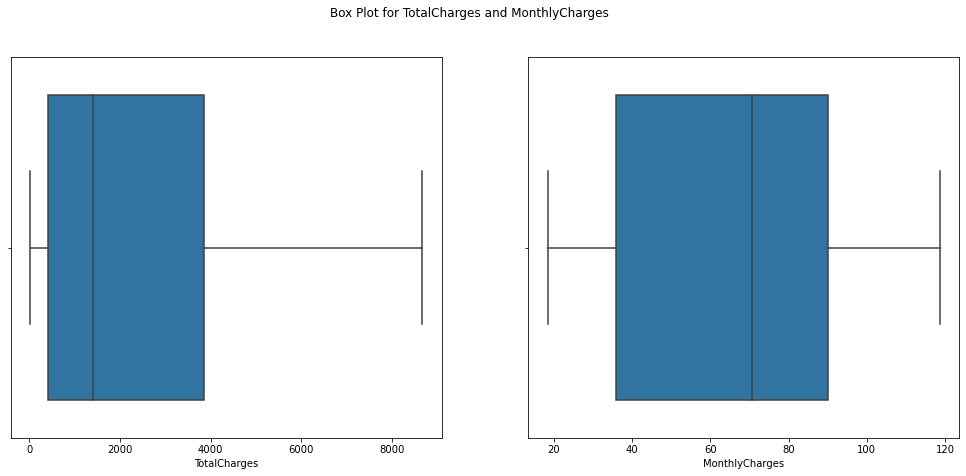

In [21]:
#Plotting box plot to visualize outliers
numerical_col=["MonthlyCharges","TotalCharges"]

fig,axes= plt.subplots(ncols=2,nrows=1,figsize=(17,7))
sns.boxplot(x=data['TotalCharges'],ax=axes[0])
sns.boxplot(x=data['MonthlyCharges'],ax=axes[1])
title =fig.suptitle('Box Plot for TotalCharges and MonthlyCharges')

plt.show()

Our numerical columns are within range ,as no outliers can be seen.